# Import Libraries & Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/insurance-claim-analysis-demographic-and-health")

print("Path to dataset files:", path)

100%|██████████| 20.5k/20.5k [00:00<00:00, 8.22MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/insurance-claim-analysis-demographic-and-health/versions/2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
df=pd.read_csv(os.path.join(path,'insurance_data.csv'))

# 2.0 Dataset

2.2 Statistics

In [ ]:
df.shape

(1340, 11)

In [ ]:
df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [ ]:
df.describe()

,index,PatientID,age,bmi,bloodpressure,children,claim
count,1340.000000,1340.000000,1335.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,669.500000,670.500000,38.078652,30.668955,94.157463,1.093284,13252.745642
std,386.968991,386.968991,11.102924,6.106735,11.434712,1.205334,12109.609288
min,0.000000,1.000000,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,334.750000,335.750000,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,669.500000,670.500000,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,1004.250000,1005.250000,47.000000,34.700000,99.000000,2.000000,16604.305000
max,1339.000000,1340.000000,60.000000,53.100000,140.000000,5.000000,63770.430000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


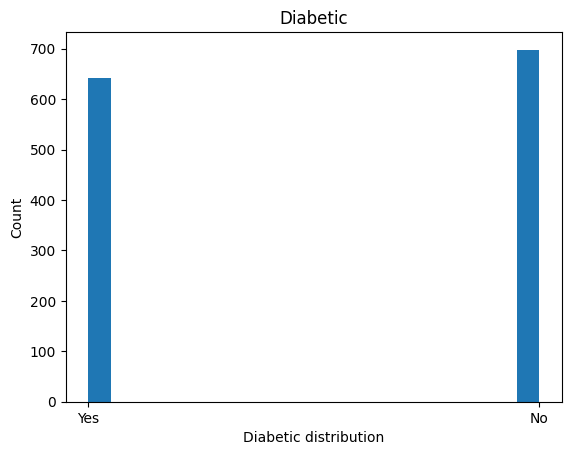

In [ ]:
plt.hist(df['diabetic'], bins=20)
plt.xlabel('Diabetic distribution')
plt.ylabel('Count')
plt.title('Diabetic')
plt.show()


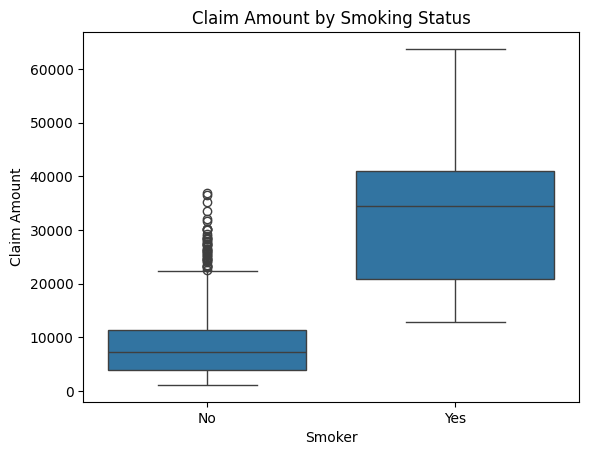

In [ ]:
sns.boxplot(x='smoker', y='claim', data=df)
plt.title('Claim Amount by Smoking Status')
plt.xlabel('Smoker')
plt.ylabel('Claim Amount')
plt.show()


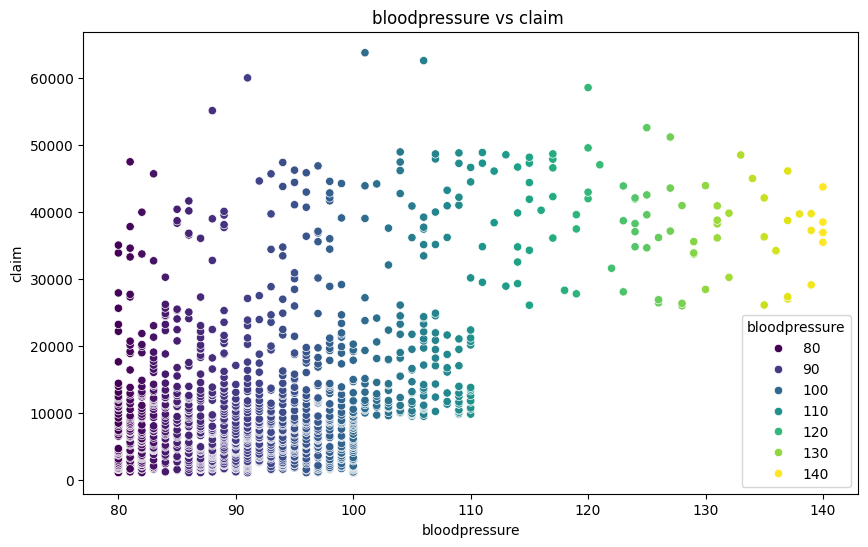

In [ ]:
feature_x = 'bloodpressure'
feature_y = 'claim'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df[feature_x], y=df[feature_y], hue=df[feature_x], palette='viridis')
plt.title(f'{feature_x} vs {feature_y} ')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title=feature_x)
plt.show()

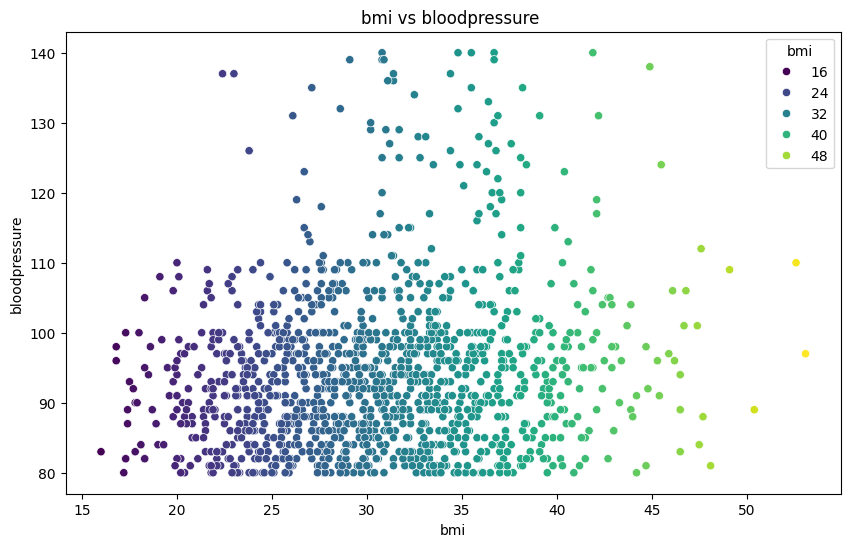

In [ ]:
feature_x = 'bmi'
feature_y = 'bloodpressure'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df[feature_x], y=df[feature_y], hue=df[feature_x], palette='viridis')
plt.title(f'{feature_x} vs {feature_y} ')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title=feature_x)
plt.show()

/tmp/ipython-input-12-3848236183.py:2: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.countplot(data = df, x = 'gender', hue = 'smoker', palette = color)


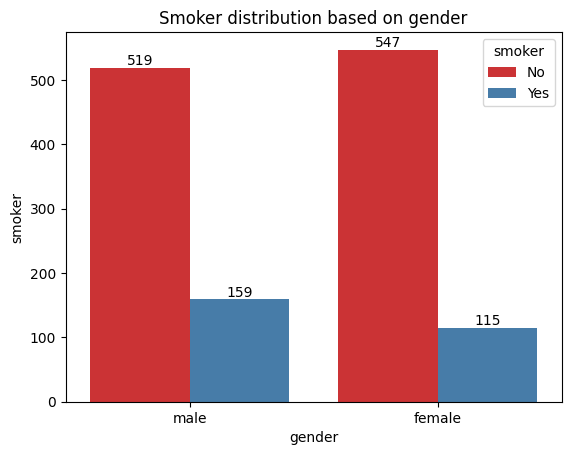

In [ ]:
color = sns.color_palette("Set1")
ax = sns.countplot(data = df, x = 'gender', hue = 'smoker', palette = color)
plt.xlabel('gender')
plt.ylabel('smoker')
plt.title('Smoker distribution based on gender')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

# 3.0 Preprocessing

Drop Uninformative Lines

In [ ]:
df = df.drop(['index', 'PatientID'], axis=1, errors='ignore')

## 3.2.1 Handling Missing Values

In [ ]:
# Step 1: Make a copy before imputation
df_before_impute = df.copy()

# Step 2: Store missing values before
missing_before = df.isnull().sum().to_frame(name='Missing Values Before')

# Step 3: Impute missing values with median (numerical) and mode (categorical)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
        else:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)

# Step 4: Store missing values after
missing_after = df.isnull().sum().to_frame(name='Missing Values After')
missing_summary = pd.concat([missing_before, missing_after], axis=1)

print("Missing Values Summary:\n", missing_summary)

# Step 5: Show rows where values were imputed
print("\nBefore Imputation:")
imputed_rows = df_before_impute[df_before_impute.isnull().any(axis=1)]
display(imputed_rows)

print("\nUpdated Rows After Imputation:")
display(df.loc[imputed_rows.index])


Missing Values Summary:
                Missing Values Before  Missing Values After
age                                5                     0
gender                             0                     0
bmi                                0                     0
bloodpressure                      0                     0
diabetic                           0                     0
children                           0                     0
smoker                             0                     0
region                             3                     0
claim                              0                     0

Before Imputation:


,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
2,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,NaN,male,34.1,100,No,0,No,northwest,1137.01
5,NaN,male,34.4,96,Yes,0,No,northwest,1137.47
6,NaN,male,37.3,86,Yes,0,No,northwest,1141.45
13,32.0,male,27.6,100,No,0,No,NaN,1252.41
14,40.0,male,28.7,81,Yes,0,No,NaN,1253.94
15,32.0,male,30.4,86,Yes,0,No,NaN,1256.30



Updated Rows After Imputation:


,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
2,38.0,male,33.3,82,Yes,0,No,southeast,1135.94
3,38.0,male,33.7,80,No,0,No,northwest,1136.40
4,38.0,male,34.1,100,No,0,No,northwest,1137.01
5,38.0,male,34.4,96,Yes,0,No,northwest,1137.47
6,38.0,male,37.3,86,Yes,0,No,northwest,1141.45
13,32.0,male,27.6,100,No,0,No,southeast,1252.41
14,40.0,male,28.7,81,Yes,0,No,southeast,1253.94
15,32.0,male,30.4,86,Yes,0,No,southeast,1256.30


## 3.2.2 Handling Duplicates

In [ ]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows before removal: {duplicate_count}")

if duplicate_count > 0:
  print("\nDuplicate Rows Preview:")
  display(df[df.duplicated()])

# Drop duplicates
df.drop_duplicates(inplace=True)

duplicate_count_after = df.duplicated().sum()
print(f"Number of duplicate rows after removal: {duplicate_count_after}")

print("\nShape of dataset after duplicate removal:", df.shape)

Number of duplicate rows before removal: 0
Number of duplicate rows after removal: 0

Shape of dataset after duplicate removal: (1340, 9)


## 3.2.3 Categorical Standardization

In [ ]:
# Store original columns for printing
original_cols = ['smoker', 'gender', 'diabetic']

# Create a copy of the DataFrame to preserve original values
df_original = df.copy()

# Display the original values before standardization
print("Values Before Standardization:")
display(df_original[original_cols].head()) # Display the first few rows

# Standardize Categorical Text in the original DataFrame
for col in df.select_dtypes(include='object').columns:
    if col in ['smoker', 'gender', 'diabetic']:  # Apply to specific columns
        df[col] = df[col].str.lower().str.strip() # Convert all strings to lowercase & remove leading/trailing spaces


# Display the values after standardization
print("\nValues After Standardization:")
display(df[original_cols].head()) # Display the first few rows after standardization

Values Before Standardization:


,smoker,gender,diabetic
0,No,male,Yes
1,No,male,No
2,No,male,Yes
3,No,male,No
4,No,male,No



Values After Standardization:


,smoker,gender,diabetic
0,no,male,yes
1,no,male,no
2,no,male,yes
3,no,male,no
4,no,male,no


## Handling Outliers (REMOVED)

In [ ]:
"""#Visualize histogram for outliers can be removed later
numeric_columns = df.select_dtypes(include=np.number).columns

# Plot histograms
for col in numeric_columns:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()"""

"#Visualize histogram for outliers can be removed later\nnumeric_columns = df.select_dtypes(include=np.number).columns\n\n# Plot histograms\nfor col in numeric_columns:\n    plt.figure(figsize=(6,4))\n    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')\n    plt.title(f'Histogram of {col}')\n    plt.xlabel(col)\n    plt.ylabel('Frequency')\n    plt.grid(axis='y', linestyle='--', alpha=0.7)\n    plt.show()"

In [ ]:
"""# Define the IQR outlier removal function
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Show shape and descriptive stats BEFORE outlier removal
print("Shape before outlier removal:", df.shape)
print("\nSummary statistics before outlier removal:")
display(df.describe())

# Store the original row count
original_rows = df.shape[0]

# Apply IQR outlier removal on all numeric columns

#numeric_columns = df.select_dtypes(include=np.number).columns.drop('claim')
# Note: The outliers in claim (or bmi and blood pressure) may not be considered as outliers, u can try using the line above and check out the model performances. (Rmb to comment the line below)
# I've also tried not removing outliers at all and the model performances are much better.

numeric_columns = df.select_dtypes(include=np.number)
for col in numeric_columns:
    before = df.shape[0]
    df = remove_outliers_iqr(df, col)
    after = df.shape[0]
    print(f"Removed {before - after} outliers from '{col}'")

# Show shape and descriptive stats AFTER outlier removal
print("\nShape after outlier removal:", df.shape)
print("\nSummary statistics after outlier removal:")
display(df.describe())

# Total number of rows removed
rows_removed = original_rows - df.shape[0]
print(f"\nTotal rows removed due to outliers: {rows_removed}")"""

'# Define the IQR outlier removal function\ndef remove_outliers_iqr(data, column):\n    Q1 = data[column].quantile(0.25)\n    Q3 = data[column].quantile(0.75)\n    IQR = Q3 - Q1\n    lower = Q1 - 1.5 * IQR\n    upper = Q3 + 1.5 * IQR\n    return data[(data[column] >= lower) & (data[column] <= upper)]\n\n# Show shape and descriptive stats BEFORE outlier removal\nprint("Shape before outlier removal:", df.shape)\nprint("\nSummary statistics before outlier removal:")\ndisplay(df.describe())\n\n# Store the original row count\noriginal_rows = df.shape[0]\n\n# Apply IQR outlier removal on all numeric columns\n\n#numeric_columns = df.select_dtypes(include=np.number).columns.drop(\'claim\')\n# Note: The outliers in claim (or bmi and blood pressure) may not be considered as outliers, u can try using the line above and check out the model performances. (Rmb to comment the line below)\n# I\'ve also tried not removing outliers at all and the model performances are much better.\n\nnumeric_columns = 

In [ ]:
"""#Visualize histogram after removing outliers can be removed later
numeric_columns = df.select_dtypes(include=np.number).columns

# Plot histograms
for col in numeric_columns:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()"""

"#Visualize histogram after removing outliers can be removed later\nnumeric_columns = df.select_dtypes(include=np.number).columns\n\n# Plot histograms\nfor col in numeric_columns:\n    plt.figure(figsize=(6,4))\n    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')\n    plt.title(f'Histogram of {col}')\n    plt.xlabel(col)\n    plt.ylabel('Frequency')\n    plt.grid(axis='y', linestyle='--', alpha=0.7)\n    plt.show()"

## 3.2.4 Feature Encoding

In [ ]:
# Columns to encode
label_encode_cols = ['gender', 'diabetic', 'smoker']
one_hot_encode_cols = ['region']

# Display original values before encoding
df_original = df.copy()
print("Before Encoding:")
display(df_original.head())

# Label Encode selected binary/ordinal columns
for col in label_encode_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# One-Hot Encode selected nominal columns
df = pd.get_dummies(df, columns=one_hot_encode_cols, prefix='region', drop_first=True, dtype=int)

# Display values after encoding
print("\nAfter Encoding:")
display(df.head())

Before Encoding:


,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,yes,0,no,southeast,1121.87
1,24.0,male,30.1,87,no,0,no,southeast,1131.51
2,38.0,male,33.3,82,yes,0,no,southeast,1135.94
3,38.0,male,33.7,80,no,0,no,northwest,1136.40
4,38.0,male,34.1,100,no,0,no,northwest,1137.01



After Encoding:


,age,gender,bmi,bloodpressure,diabetic,children,smoker,claim,region_northwest,region_southeast,region_southwest
0,39.0,1,23.2,91,1,0,0,1121.87,0,1,0
1,24.0,1,30.1,87,0,0,0,1131.51,0,1,0
2,38.0,1,33.3,82,1,0,0,1135.94,0,1,0
3,38.0,1,33.7,80,0,0,0,1136.40,1,0,0
4,38.0,1,34.1,100,0,0,0,1137.01,1,0,0


## 3.2.5 Feature Scaling

In [ ]:
# Select numerical columns
numerical_columns = ['age', 'bmi', 'bloodpressure', 'claim']

original_numerical_robust = df[numerical_columns].copy()

# Apply Robust Scaling
robust_scaler = RobustScaler()
df[numerical_columns] = robust_scaler.fit_transform(df[numerical_columns])

# Display values before and after Robust Scaling
print("Before Robust Scaling:")
display(original_numerical_robust.head())

print("\nAfter Robust Scaling:")
display(df[numerical_columns].head())

Before Robust Scaling:


,age,bmi,bloodpressure,claim
0,39.0,23.2,91,1121.87
1,24.0,30.1,87,1131.51
2,38.0,33.3,82,1135.94
3,38.0,33.7,80,1136.40
4,38.0,34.1,100,1137.01



After Robust Scaling:


,age,bmi,bloodpressure,claim
0,0.055556,-0.854599,-0.076923,-0.693985
1,-0.777778,-0.035608,-0.384615,-0.693174
2,0.000000,0.344214,-0.769231,-0.692801
3,0.000000,0.391691,-0.923077,-0.692762
4,0.000000,0.439169,0.615385,-0.692711


## 3.2.6 Previewed Dataset

In [ ]:
print("Final Dataset Shape:", df.shape)
print("\nFinal Dataset Preview:")
df.head()

Final Dataset Shape: (1340, 11)

Final Dataset Preview:


,age,gender,bmi,bloodpressure,diabetic,children,smoker,claim,region_northwest,region_southeast,region_southwest
0,0.055556,1,-0.854599,-0.076923,1,0,0,-0.693985,0,1,0
1,-0.777778,1,-0.035608,-0.384615,0,0,0,-0.693174,0,1,0
2,0.000000,1,0.344214,-0.769231,1,0,0,-0.692801,0,1,0
3,0.000000,1,0.391691,-0.923077,0,0,0,-0.692762,1,0,0
4,0.000000,1,0.439169,0.615385,0,0,0,-0.692711,1,0,0


# 4.0 Techniques Used (Initialize + TrainTestSplit)

### 4.1 Linear Regression

4.1.1 Initializing

In [ ]:
# Initialize Linear Regression model
linear_model = LinearRegression()

4.1.2 Train-test

In [ ]:
# Define features and target
X = df.drop("claim", axis=1)
y = df["claim"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
linear_model.fit(X_train, y_train)

LinearRegression()

### 4.2 Decision Tree

4.2.1 Initialize

In [ ]:
# Initialize Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)

4.2.2 Train-test

In [ ]:
# Train Decision Tree model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### 4.3 Random Forest

4.3.1 Initialize

In [ ]:
# Initialize Random Forest Regressor
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

4.3.2 Train-test

In [ ]:
# Train Random Forest model
forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 4.4 K-Nearest Neighbors

4.4.1 Initialize

In [ ]:
# Initialize K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)

4.4.2 Train-test

In [ ]:
# Train K-Nearest Neighbors model
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

# 5.0 Model Validation (kfold cross validation + performance metrics)

## 5.1 Model Evaluation

### 5.1.1 Linear Regression

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Generate predictions using the trained linear regression model
y_pred_lr = linear_model.predict(X_test)

# Calculate metrics
lr_r2 = r2_score(y_test, y_pred_lr) * 100
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

# Print results
print("Linear Regression Model Evaluation:")
print(f"R-squared (R²): {lr_r2:.2f}%")
print(f"Mean Squared Error (MSE): {lr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {lr_mae:.4f}")

Linear Regression Model Evaluation:
R-squared (R²): 73.98%
Mean Squared Error (MSE): 0.3027
Root Mean Squared Error (RMSE): 0.5502
Mean Absolute Error (MAE): 0.4116


### 5.1.2 Decision Tree

In [ ]:
# Make predictions first
y_pred_dt = tree_model.predict(X_test)

# Evaluation metrics
dt_r2 = r2_score(y_test, y_pred_dt) * 100
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, y_pred_dt)

# Print results
print("Decision Tree Model Evaluation:")
print(f"R-squared (R²): {dt_r2:.2f}%")
print(f"Mean Squared Error (MSE): {dt_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {dt_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {dt_mae:.4f}")

Decision Tree Model Evaluation:
R-squared (R²): 63.08%
Mean Squared Error (MSE): 0.4294
Root Mean Squared Error (RMSE): 0.6553
Mean Absolute Error (MAE): 0.4737


### 5.1.3 Random Forest

In [ ]:
# Predict first
y_pred_rf = forest_model.predict(X_test)

# Evaluation
rf_r2 = r2_score(y_test, y_pred_rf) * 100
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

# Print results
print("Random Forest Model Evaluation:")
print(f"R-squared (R²): {rf_r2:.2f}%")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")

Random Forest Model Evaluation:
R-squared (R²): 82.30%
Mean Squared Error (MSE): 0.2059
Root Mean Squared Error (RMSE): 0.4538
Mean Absolute Error (MAE): 0.3352


### 5.1.4 K-Nearest Neighbors

In [ ]:
# Predict first
y_pred_knn = knn_model.predict(X_test)

# Evaluation
knn_r2 = r2_score(y_test, y_pred_knn) * 100
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_rmse = np.sqrt(knn_mse)
knn_mae = mean_absolute_error(y_test, y_pred_knn)

# Print results
print("K-Nearest Neighbors Model Evaluation:")
print(f"R-squared (R²): {knn_r2:.2f}%")
print(f"Mean Squared Error (MSE): {knn_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {knn_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {knn_mae:.4f}")

K-Nearest Neighbors Model Evaluation:
R-squared (R²): 62.98%
Mean Squared Error (MSE): 0.4306
Root Mean Squared Error (RMSE): 0.6562
Mean Absolute Error (MAE): 0.4531


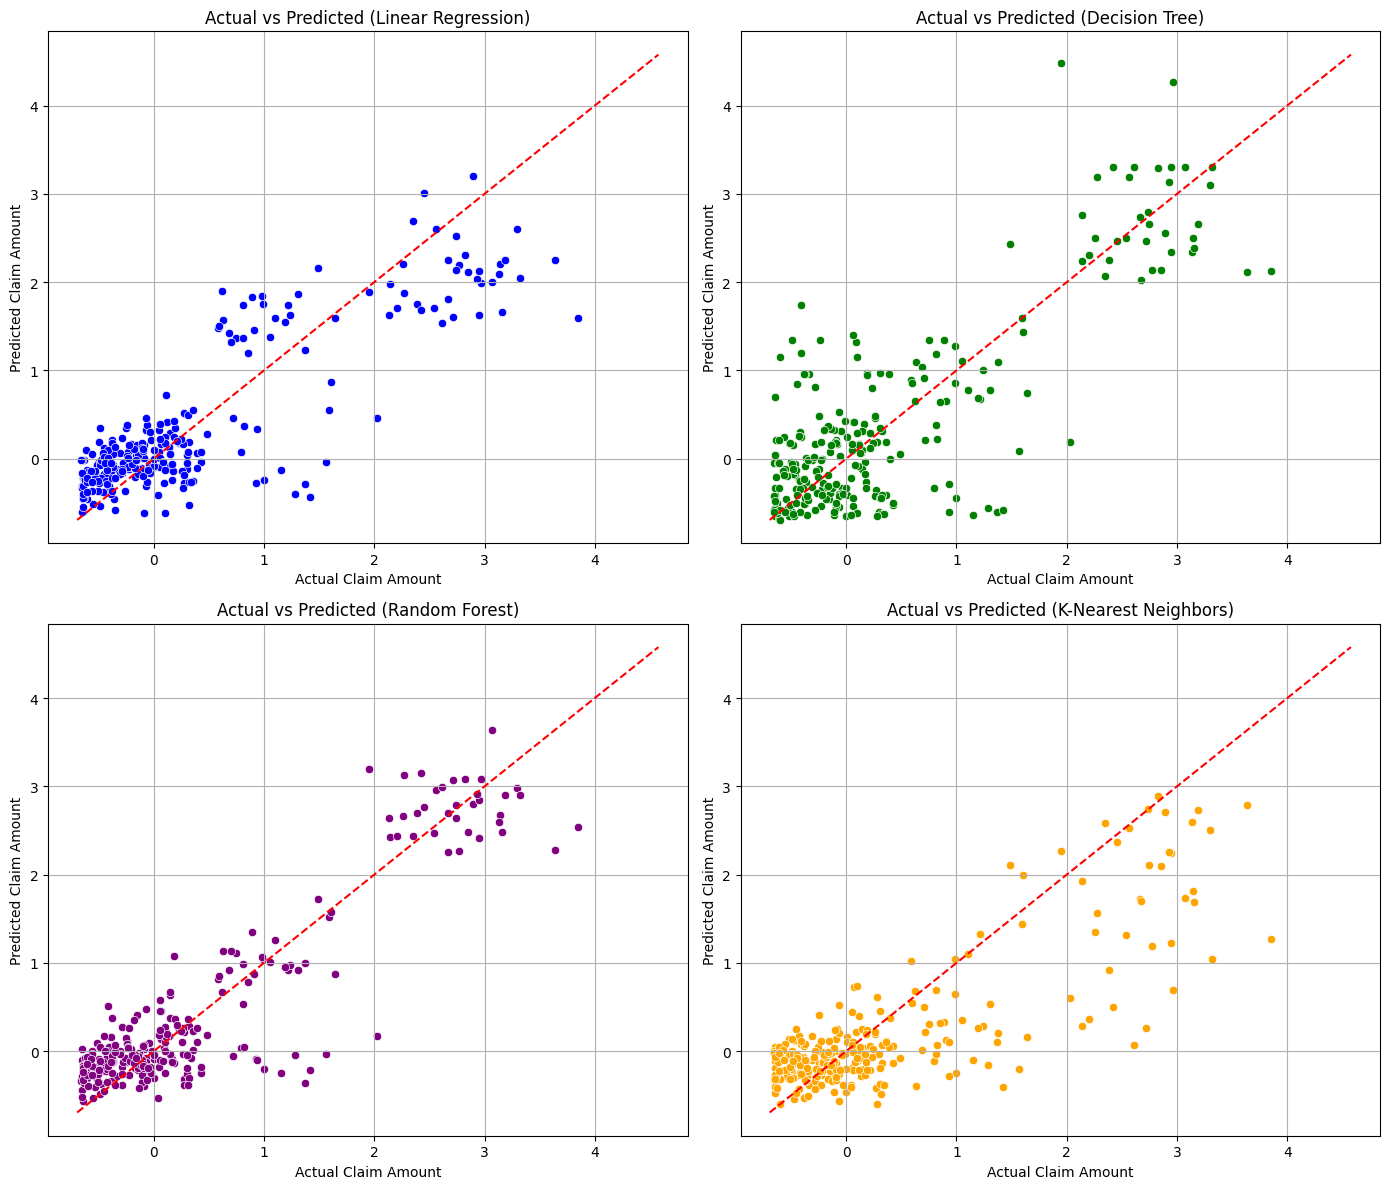

In [ ]:
# Scatterplot for Actual VS Predicted Claim Amount
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Linear Regression
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', ax=axes[0, 0])
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('Actual vs Predicted (Linear Regression)')
axes[0, 0].set_xlabel('Actual Claim Amount')
axes[0, 0].set_ylabel('Predicted Claim Amount')
axes[0, 0].grid(True)

# Decision Tree
sns.scatterplot(x=y_test, y=y_pred_dt, color='green', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('Actual vs Predicted (Decision Tree)')
axes[0, 1].set_xlabel('Actual Claim Amount')
axes[0, 1].set_ylabel('Predicted Claim Amount')
axes[0, 1].grid(True)

# Random Forest
sns.scatterplot(x=y_test, y=y_pred_rf, color='purple', ax=axes[1, 0])
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[1, 0].set_title('Actual vs Predicted (Random Forest)')
axes[1, 0].set_xlabel('Actual Claim Amount')
axes[1, 0].set_ylabel('Predicted Claim Amount')
axes[1, 0].grid(True)

# K-Nearest Neighbors
sns.scatterplot(x=y_test, y=y_pred_knn, color='orange', ax=axes[1, 1])
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[1, 1].set_title('Actual vs Predicted (K-Nearest Neighbors)')
axes[1, 1].set_xlabel('Actual Claim Amount')
axes[1, 1].set_ylabel('Predicted Claim Amount')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## 5.2 Cross Validation

### 5.2.1 Linear Regression Model

In [ ]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
}

# Run cross-validation
cv_results = cross_validate(linear_model, X_train, y_train, cv=kf, scoring=scoring)

# Calculate averages
lr_avg_r2 = np.mean(cv_results['test_r2']) * 100
lr_avg_mse = -np.mean(cv_results['test_mse'])
lr_avg_rmse = -np.mean(cv_results['test_rmse'])
lr_avg_mae = -np.mean(cv_results['test_mae'])

# Calculate standard deviations
lr_std_r2 = np.std(cv_results['test_r2']) * 100
lr_std_mse = np.std(-cv_results['test_mse'])
lr_std_rmse = np.std(-cv_results['test_rmse'])
lr_std_mae = np.std(-cv_results['test_mae'])

# Print results
print("Linear Regression Model Cross Validation:")
print(f"R-squared (R²): {lr_avg_r2:.2f}% ± {lr_std_r2:.2f}%")
print(f"MSE: {lr_avg_mse:.4f} ± {lr_std_mse:.4f}")
print(f"RMSE: {lr_avg_rmse:.4f} ± {lr_std_rmse:.4f}")
print(f"MAE: {lr_avg_mae:.4f} ± {lr_std_mae:.4f}")

Linear Regression Model Cross Validation:
R-squared (R²): 68.80% ± 2.74%
MSE: 0.3135 ± 0.0522
RMSE: 0.5579 ± 0.0471
MAE: 0.4201 ± 0.0263


### 5.2.2 Decision Tree Model

In [ ]:
# Perform cross-validation using the correct model variable
cv_results = cross_validate(tree_model, X_train, y_train, cv=kf, scoring=scoring)

# Calculate average scores
dt_avg_r2 = np.mean(cv_results['test_r2']) * 100
dt_avg_mse = -np.mean(cv_results['test_mse'])
dt_avg_rmse = -np.mean(cv_results['test_rmse'])
dt_avg_mae = -np.mean(cv_results['test_mae'])

# Calculate standard deviations
dt_std_r2 = np.std(cv_results['test_r2']) * 100
dt_std_mse = np.std(-cv_results['test_mse'])
dt_std_rmse = np.std(-cv_results['test_rmse'])
dt_std_mae = np.std(-cv_results['test_mae'])

# Print results
print("Decision Tree Model Cross Validation:")
print(f"R-squared (R²): {dt_avg_r2:.2f}% ± {dt_std_r2:.2f}%")
print(f"MSE: {dt_avg_mse:.4f} ± {dt_std_mse:.4f}")
print(f"RMSE: {dt_avg_rmse:.4f} ± {dt_std_rmse:.4f}")
print(f"MAE: {dt_avg_mae:.4f} ± {dt_std_mae:.4f}")

Decision Tree Model Cross Validation:
R-squared (R²): 55.57% ± 6.42%
MSE: 0.4382 ± 0.0208
RMSE: 0.6618 ± 0.0157
MAE: 0.4695 ± 0.0150


### 5.2.3 Random Forest Model

In [ ]:
# Perform cross-validation
cv_results = cross_validate(forest_model, X_train, y_train, cv=kf, scoring=scoring)

# Calculate average metrics
rf_avg_r2 = np.mean(cv_results['test_r2']) * 100
rf_avg_mse = -np.mean(cv_results['test_mse'])
rf_avg_rmse = -np.mean(cv_results['test_rmse'])
rf_avg_mae = -np.mean(cv_results['test_mae'])

# Calculate standard deviations
rf_std_r2 = np.std(cv_results['test_r2']) * 100
rf_std_mse = np.std(-cv_results['test_mse'])
rf_std_rmse = np.std(-cv_results['test_rmse'])
rf_std_mae = np.std(-cv_results['test_mae'])

# Print results
print("Random Forest Model Cross Validation:")
print(f"R-squared (R²): {rf_avg_r2:.2f}% ± {rf_std_r2:.2f}%")
print(f"MSE: {rf_avg_mse:.4f} ± {rf_std_mse:.4f}")
print(f"RMSE: {rf_avg_rmse:.4f} ± {rf_std_rmse:.4f}")
print(f"MAE: {rf_avg_mae:.4f} ± {rf_std_mae:.4f}")

Random Forest Model Cross Validation:
R-squared (R²): 78.80% ± 1.86%
MSE: 0.2129 ± 0.0338
RMSE: 0.4598 ± 0.0374
MAE: 0.3442 ± 0.0205


### 5.2.4 KNN Model

In [ ]:
# Perform cross-validation
cv_results = cross_validate(knn_model, X_train, y_train, cv=kf, scoring=scoring)

# Calculate average metrics
knn_avg_r2 = np.mean(cv_results['test_r2']) * 100
knn_avg_mse = -np.mean(cv_results['test_mse'])
knn_avg_rmse = -np.mean(cv_results['test_rmse'])
knn_avg_mae = -np.mean(cv_results['test_mae'])

# Calculate standard deviations
knn_std_r2 = np.std(cv_results['test_r2']) * 100
knn_std_mse = np.std(-cv_results['test_mse'])
knn_std_rmse = np.std(-cv_results['test_rmse'])
knn_std_mae = np.std(-cv_results['test_mae'])

# Print results
print("K-Nearest Neighbors Model Cross Validation:")
print(f"R-squared (R²): {knn_avg_r2:.2f}% ± {knn_std_r2:.2f}%")
print(f"MSE: {knn_avg_mse:.4f} ± {knn_std_mse:.4f}")
print(f"RMSE: {knn_avg_rmse:.4f} ± {knn_std_rmse:.4f}")
print(f"MAE: {knn_avg_mae:.4f} ± {knn_std_mae:.4f}")

K-Nearest Neighbors Model Cross Validation:
R-squared (R²): 55.83% ± 7.64%
MSE: 0.4419 ± 0.0962
RMSE: 0.6612 ± 0.0680
MAE: 0.4597 ± 0.0412
